In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [5]:
# Load dataset
iris = load_iris()
X = iris.data      # shape (150,4)
y = iris.target    # shape (150,)
class_names = iris.target_names
print("Feature shape:", X.shape)
print("Label shape:", y.shape)

Feature shape: (150, 4)
Label shape: (150,)


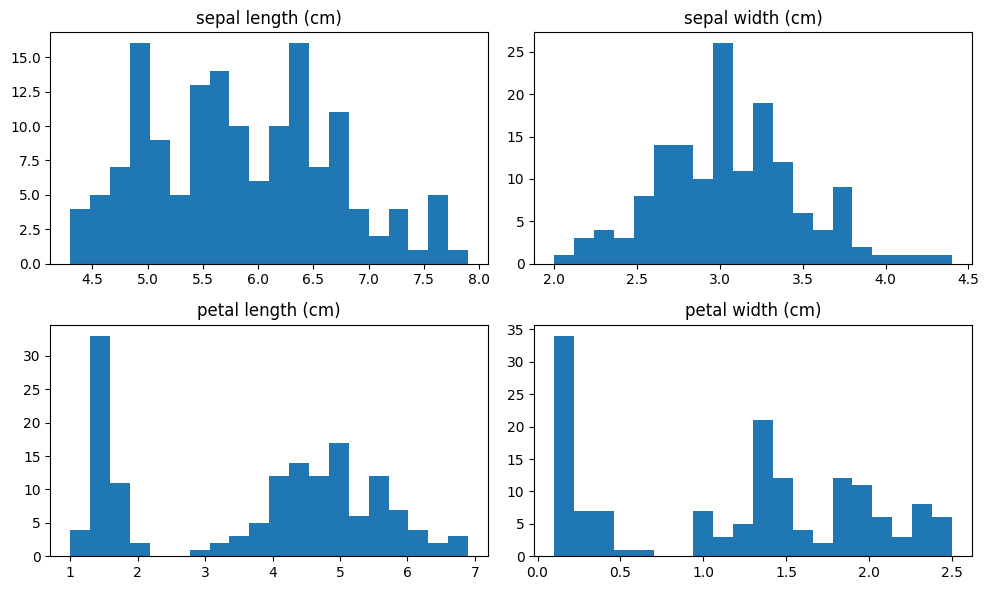

In [6]:
# Histogram
plt.figure(figsize=(10,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(X[:,i], bins=20)
    plt.title(iris.feature_names[i])

plt.tight_layout()
plt.show()

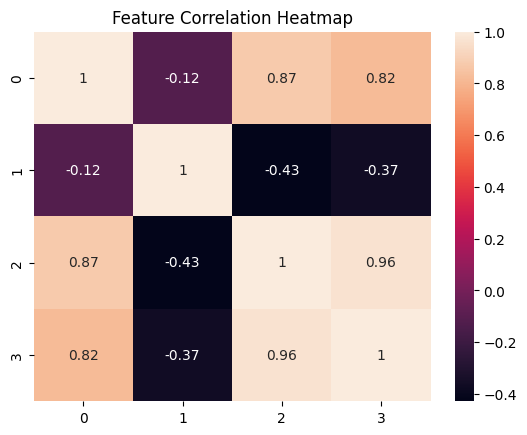

In [7]:
# Correlation heatmap
sns.heatmap(np.corrcoef(X.T), annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
# Train / Validation / Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(105, 4) (22, 4) (23, 4)


In [9]:
# Standardization (Z-score normalization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [10]:
# One-Hot Encoding
def one_hot(y, num_classes=3):
    encoded = np.zeros((len(y), num_classes))
    encoded[np.arange(len(y)), y] = 1
    return encoded

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
y_test_oh  = one_hot(y_test)

In [11]:
# Neural Network Implementation
def initialize_parameters():

    np.random.seed(42)

    params = {

        "W1": np.random.randn(4,8) * np.sqrt(1/4),
        "b1": np.zeros((1,8)),

        "W2": np.random.randn(8,6) * np.sqrt(1/8),
        "b2": np.zeros((1,6)),

        "W3": np.random.randn(6,3) * np.sqrt(1/6),
        "b3": np.zeros((1,3))
    }

    return params

In [12]:
# Sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s*(1-s)

In [13]:
# softmax
def softmax(x):

    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

In [14]:
# Forward Propagation
def forward_propagation(X, params):

    Z1 = X @ params["W1"] + params["b1"]
    A1 = sigmoid(Z1)

    Z2 = A1 @ params["W2"] + params["b2"]
    A2 = sigmoid(Z2)

    Z3 = A2 @ params["W3"] + params["b3"]
    A3 = softmax(Z3)

    cache = (Z1,A1,Z2,A2,Z3,A3)

    return A3, cache

In [15]:
# loss function
def compute_loss(y_true, y_pred):

    m = y_true.shape[0]

    loss = -np.sum(y_true * np.log(y_pred+1e-8)) / m

    return loss

In [16]:
# Backpropagation
def backward_propagation(X, y, params, cache):

    Z1,A1,Z2,A2,Z3,A3 = cache

    m = X.shape[0]

    dZ3 = A3 - y
    dW3 = A2.T @ dZ3 / m
    db3 = np.sum(dZ3, axis=0, keepdims=True)/m

    dA2 = dZ3 @ params["W3"].T
    dZ2 = dA2 * sigmoid_derivative(Z2)
    dW2 = A1.T @ dZ2 / m
    db2 = np.sum(dZ2, axis=0, keepdims=True)/m

    dA1 = dZ2 @ params["W2"].T
    dZ1 = dA1 * sigmoid_derivative(Z1)
    dW1 = X.T @ dZ1 / m
    db1 = np.sum(dZ1, axis=0, keepdims=True)/m

    grads = {

        "dW1":dW1,
        "db1":db1,
        "dW2":dW2,
        "db2":db2,
        "dW3":dW3,
        "db3":db3
    }

    return grads


In [17]:
# Update Parameters
def update_parameters(params, grads, lr):

    params["W1"] -= lr * grads["dW1"]
    params["b1"] -= lr * grads["db1"]

    params["W2"] -= lr * grads["dW2"]
    params["b2"] -= lr * grads["db2"]

    params["W3"] -= lr * grads["dW3"]
    params["b3"] -= lr * grads["db3"]

    return params


In [18]:
# Accuracy Function
def accuracy(X, y, params):

    pred,_ = forward_propagation(X, params)

    pred_class = np.argmax(pred, axis=1)

    return np.mean(pred_class == y)


In [19]:
# Training Loop
def train(X_train, y_train, X_val, y_val,
          epochs=1000, lr=0.01, batch_size=16):

    params = initialize_parameters()

    train_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):

        indices = np.random.permutation(len(X_train))

        for i in range(0, len(X_train), batch_size):

            batch_idx = indices[i:i+batch_size]

            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            pred, cache = forward_propagation(X_batch, params)

            loss = compute_loss(y_batch, pred)

            grads = backward_propagation(X_batch, y_batch, params, cache)

            params = update_parameters(params, grads, lr)

        if epoch % 50 == 0:

            train_loss_history.append(loss)

            val_acc = accuracy(X_val, np.argmax(y_val,axis=1), params)
            val_acc_history.append(val_acc)

            print(f"Epoch {epoch}, Loss {loss:.4f}, Val Acc {val_acc:.4f}")

    return params, train_loss_history, val_acc_history


In [20]:
# Train Model
params, loss_hist, val_hist = train(
    X_train, y_train_oh, X_val, y_val_oh)


Epoch 0, Loss 1.1554, Val Acc 0.2727
Epoch 50, Loss 1.0977, Val Acc 0.2727
Epoch 100, Loss 1.0429, Val Acc 0.2727
Epoch 150, Loss 0.9929, Val Acc 0.4091
Epoch 200, Loss 0.9305, Val Acc 0.8636
Epoch 250, Loss 0.8788, Val Acc 0.8636
Epoch 300, Loss 0.7667, Val Acc 0.8636
Epoch 350, Loss 0.7757, Val Acc 0.9091
Epoch 400, Loss 0.7548, Val Acc 0.9091
Epoch 450, Loss 0.5836, Val Acc 0.9091
Epoch 500, Loss 0.5488, Val Acc 0.9091
Epoch 550, Loss 0.4673, Val Acc 0.9545
Epoch 600, Loss 0.4861, Val Acc 0.9545
Epoch 650, Loss 0.4732, Val Acc 0.9545
Epoch 700, Loss 0.5639, Val Acc 1.0000
Epoch 750, Loss 0.4046, Val Acc 1.0000
Epoch 800, Loss 0.4388, Val Acc 1.0000
Epoch 850, Loss 0.3267, Val Acc 1.0000
Epoch 900, Loss 0.3972, Val Acc 1.0000
Epoch 950, Loss 0.5460, Val Acc 1.0000


In [21]:
# Test Accuracy
test_acc = accuracy(X_test, y_test, params)

print("Test Accuracy:", test_acc)


Test Accuracy: 0.8695652173913043


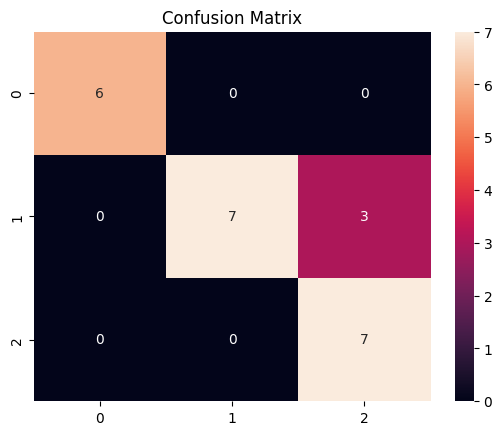

In [22]:
# Confusion Matrix
pred,_ = forward_propagation(X_test, params)

pred_class = np.argmax(pred, axis=1)

cm = confusion_matrix(y_test, pred_class)

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.show()


In [23]:
# Classification Report
print(classification_report(y_test, pred_class))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.70      0.82        10
           2       0.70      1.00      0.82         7

    accuracy                           0.87        23
   macro avg       0.90      0.90      0.88        23
weighted avg       0.91      0.87      0.87        23



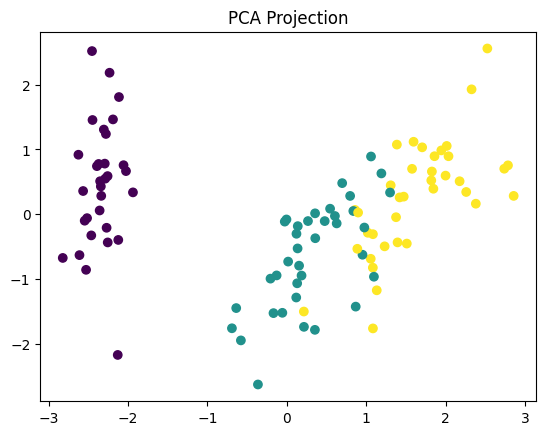

In [24]:
# Decision Boundary using PCA
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_train)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train)
plt.title("PCA Projection")
plt.show()


In [26]:
# Compare with sklearn MLP
mlp = MLPClassifier(hidden_layer_sizes=(8,6),
                    max_iter=1000)

mlp.fit(X_train, y_train)

print("Sklearn Accuracy:",
      mlp.score(X_test, y_test))


Sklearn Accuracy: 1.0


D:\Deep_Learning_Coding\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
